In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import pandas as pd
import os
import tiktoken

In [104]:
df = pd.read_csv('./processed/thy_diary.csv')
df.columns

Index(['date', 'code', 'diary_text'], dtype='object')

In [105]:
# 음력 날짜 지우기
def clean_str(x):
    x1 = re.sub(r'\(([^)]*\d+)일,\s', '(', str(x))
    return x1

df['diary_text'] = df['diary_text'].apply(clean_str)
df

,date,code,diary_text
0,1883-01-01,sa_024r_0010_0010_0010,"1883년(명치 16) 1월 1일(월, 맑고 춥다) 관직·빈부·귀천을 막론하고 모두..."
1,1883-01-02,sa_024r_0010_0010_0020,"2일(화, 맑음) 고우장(古愚丈: 김옥균)과 함께 후쿠자와 유키치(福澤諭吉)를 방문..."
2,1883-01-03,sa_024r_0010_0010_0030,"3일(수, 맑고 춥다) 이날 오전에 고우장(古愚丈: 김옥균)과 같이 가미즈키(上月)..."
3,1883-01-04,sa_024r_0010_0010_0040,"4일(목, 맑고 춥다) 아침 10시 기차로 고우(古愚: 김옥균), 각치공(覺治公: ..."
4,1883-01-05,sa_024r_0010_0010_0050,"5일(금, 맑고 춥다) 아침에 북해(北海:손붕구 孫鵬九) 씨 댁에 가서 종기가 난 ..."
...,...,...,...
2279,1889-12-27,sa_024r_0070_0130_0360,27일 《금요일》 아침에는 흐렸으나 오후에는 맑음.맥컬리가 쓴 『역사』를 읽었다. ...
2280,1889-12-28,sa_024r_0070_0130_0370,28일 《토요일》 상쾌한 날씨. 알렌(Allen) 박사와 본넬(Bonnell) 교수...
2281,1889-12-29,sa_024r_0070_0130_0380,"29일 《일요일》 비가 내렸지만 따뜻함. 지난 몇 주 동안, 북쪽 기숙사 온도는 화..."
2282,1889-12-30,sa_024r_0070_0130_0390,30일 《월요일》 몹시 추움. 불쏘시개와 석탄을 찾아 벽난로를 다시 켰어야 할 만큼...


In [106]:
df["combined"] = (
    "Date: " + df.date.str.strip() + "; Content: " + df.diary_text.str.strip()
)
df

,date,code,diary_text,combined
0,1883-01-01,sa_024r_0010_0010_0010,"1883년(명치 16) 1월 1일(월, 맑고 춥다) 관직·빈부·귀천을 막론하고 모두...",Date: 1883-01-01; Content: 1883년(명치 16) 1월 1일(...
1,1883-01-02,sa_024r_0010_0010_0020,"2일(화, 맑음) 고우장(古愚丈: 김옥균)과 함께 후쿠자와 유키치(福澤諭吉)를 방문...","Date: 1883-01-02; Content: 2일(화, 맑음) 고우장(古愚丈: ..."
2,1883-01-03,sa_024r_0010_0010_0030,"3일(수, 맑고 춥다) 이날 오전에 고우장(古愚丈: 김옥균)과 같이 가미즈키(上月)...","Date: 1883-01-03; Content: 3일(수, 맑고 춥다) 이날 오전에..."
3,1883-01-04,sa_024r_0010_0010_0040,"4일(목, 맑고 춥다) 아침 10시 기차로 고우(古愚: 김옥균), 각치공(覺治公: ...","Date: 1883-01-04; Content: 4일(목, 맑고 춥다) 아침 10시..."
4,1883-01-05,sa_024r_0010_0010_0050,"5일(금, 맑고 춥다) 아침에 북해(北海:손붕구 孫鵬九) 씨 댁에 가서 종기가 난 ...","Date: 1883-01-05; Content: 5일(금, 맑고 춥다) 아침에 북해..."
...,...,...,...,...
2279,1889-12-27,sa_024r_0070_0130_0360,27일 《금요일》 아침에는 흐렸으나 오후에는 맑음.맥컬리가 쓴 『역사』를 읽었다. ...,Date: 1889-12-27; Content: 27일 《금요일》 아침에는 흐렸으나...
2280,1889-12-28,sa_024r_0070_0130_0370,28일 《토요일》 상쾌한 날씨. 알렌(Allen) 박사와 본넬(Bonnell) 교수...,Date: 1889-12-28; Content: 28일 《토요일》 상쾌한 날씨. 알...
2281,1889-12-29,sa_024r_0070_0130_0380,"29일 《일요일》 비가 내렸지만 따뜻함. 지난 몇 주 동안, 북쪽 기숙사 온도는 화...",Date: 1889-12-29; Content: 29일 《일요일》 비가 내렸지만 따...
2282,1889-12-30,sa_024r_0070_0130_0390,30일 《월요일》 몹시 추움. 불쏘시개와 석탄을 찾아 벽난로를 다시 켰어야 할 만큼...,Date: 1889-12-30; Content: 30일 《월요일》 몹시 추움. 불쏘...


In [107]:
#  cl100k_base는 토크나이저다. 임베딩과는 큰 관련이 없다.
tokenizer = tiktoken.get_encoding("cl100k_base")
type(df.diary_text[0])

str

In [109]:
# 소요되는 토큰을 각 칼럼에 저장하기. apply 함수가 쓰였다!
df['n_tokens'] = df['combined'].apply(lambda x: len(tokenizer.encode(str(x))))

In [110]:
df = df[['combined', 'n_tokens']]
df.head(10)

,combined,n_tokens
0,Date: 1883-01-01; Content: 1883년(명치 16) 1월 1일(...,559
1,"Date: 1883-01-02; Content: 2일(화, 맑음) 고우장(古愚丈: ...",405
2,"Date: 1883-01-03; Content: 3일(수, 맑고 춥다) 이날 오전에...",2778
3,"Date: 1883-01-04; Content: 4일(목, 맑고 춥다) 아침 10시...",422
4,"Date: 1883-01-05; Content: 5일(금, 맑고 춥다) 아침에 북해...",387
5,"Date: 1883-01-06; Content: 6일(토, 맑고 춥다) 간밤에 류마...",963
6,"Date: 1883-01-07; Content: 7일(일, 맑음) 종일 종기로 몹시...",154
7,"Date: 1883-01-08; Content: 8일(월, 맑음) 밤새도록 통증이 ...",58
8,"Date: 1883-01-09; Content: 9일(화, 맑음) 이날 아침부터 통...",143
9,"Date: 1883-01-10; Content: 10일(수, 아침에 맑고 저녁에 비...",278


<Axes: >

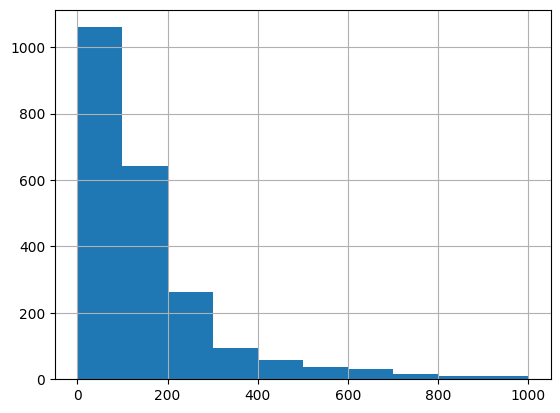

In [111]:
# 히스토그램으로 그려서 보기
df.n_tokens.hist(range=(0, 1000))

In [112]:
df[df['n_tokens'] > 4000]

,combined,n_tokens
36,"Date: 1883-11-07; Content: 7일(수, 맑음, 삼가다) 이날 낮...",5335
91,"Date: 1884-01-01; Content: 1월 1일(화, 맑음, 삼가다) 이...",6306
108,"Date: 1884-01-18; Content: 18일(금, 맑음, 삼가다) 이날 ...",6843
414,"Date: 1884-11-19; Content: 19일(수, 맑음, 삼가다) 아침에...",5644
429,"Date: 1884-12-04; Content: 4일(목, 맑음, 삼가다) 아침에 ...",4232


In [113]:
max_tokens = 3000

# 너무 입력 문장이 길다 싶으면 여러 문장으로 쪼개는 함수
def split_into_many(text, max_tokens = max_tokens):

    # 일단 문장으로 쪼개기
    sentences = text.split('. ')

    # 문장마다 몇 토큰 들어가는지 세어 주기.
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []


    for sentence, token in zip(sentences, n_tokens):

        # 문장의 토큰 수와 현재까지의 토큰 수의 합이 최대 토큰 수를 초과하면, 해당 청크를 청크 목록에 추가하고 청크 및 현재까지의 토큰 수를 초기화한다.
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0


        if token > max_tokens:
            continue

        chunk.append(sentence)
        tokens_so_far += token + 1

    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks

In [114]:
shortened = []
# 데이터 프레임 순회하기
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['combined'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['combined'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['combined'] )

<Axes: >

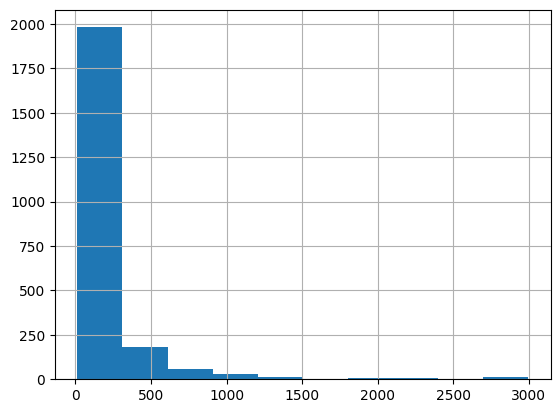

In [117]:
df = pd.DataFrame(shortened, columns = ['combined'])
df['n_tokens'] = df.combined.apply(lambda x: len(tokenizer.encode(str(x))))
df.n_tokens.hist()

## Embedding

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv('.env'))
from openai import OpenAI
import openai
client = OpenAI()
openai.api_key  = os.getenv('OPENAI_API_KEY')

In [3]:
# 텍스트를 embedding화한다. (몇 분 이상 걸릴 수 있다)
df['embeddings'] = df.combined.apply(lambda x: client.embeddings.create(input=x, model='text-embedding-ada-002').data[0].embedding)
df.to_csv('processed/thy_embeddings.csv')
df=pd.read_csv('processed/thy_embeddings.csv', index_col=0)
df.head()

NameError: name 'df' is not defined

In [28]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine

df=pd.read_csv('thy_embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array).apply(lambda x: [float(i) for i in x]) # eval 함수를 적용하는 이유는 csv이기 때문이다. 임베딩을 혹시라도 문자열로 곧이곧대로 판단하지 않도록 하기 위함.
df.head()

,combined,n_tokens,embeddings
0,Date: 1883-01-01; Content: 1883년(명치 16) 1월 1일(...,559,"[-0.01074959710240364, -0.015057748183608055, ..."
1,"Date: 1883-01-02; Content: 2일(화, 맑음) 고우장(古愚丈: ...",405,"[0.003885359736159444, -0.006819339003413916, ..."
2,"Date: 1883-01-03; Content: 3일(수, 맑고 춥다) 이날 오전에...",2778,"[-0.004177005961537361, -0.008521092124283314,..."
3,"Date: 1883-01-04; Content: 4일(목, 맑고 춥다) 아침 10시...",422,"[-0.019375553354620934, -0.016086915507912636,..."
4,"Date: 1883-01-05; Content: 5일(금, 맑고 춥다) 아침에 북해...",387,"[-0.0006925069028511643, -0.014644294045865536..."


In [14]:
import pickle

with open('thy_embedding.pkl', 'wb') as f:
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

In [22]:
with open('../data/processed/thy-embedding.pkl', 'rb') as f:
    df = pickle.load(f)

In [23]:
type(df['embeddings'][0][0])

numpy.float64

In [24]:
def create_context(
    question, df, max_len=1800
):
    """
    데이터 프레임으로부터 가장 유사한 문서를 찾아서, 질문에 대한 문맥을 만든다.
    """

    # 질문으로부터 임베딩을 만든다.
    q_embeddings = client.embeddings.create(input=question, model='text-embedding-ada-002').data[0].embedding

    # 임베딩으로부터 거리를 계산한다.
    df["distances"] = df["embeddings"].apply(lambda x: cosine(q_embeddings, x))
    returns = []
    cur_len = 0
    # 거리순으로 정렬하고, 문맥이 너무 길어지기 전까지만 텍스트를 문맥에 추가한다.
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        

        # 현재 토큰 수에 텍스트 길이를 더한다.
        cur_len += row['n_tokens'] + 4
        
        # 문맥이 너무 길어지면, break
        if cur_len > max_len:
            break
        

        # 아니면, 문맥에 추가한다.
        returns.append(row["combined"])

    # Return the context
    return "\n\n###\n\n".join(returns)


# 이 함수가 하는 일 다시 정리해보자.
# 1. 질문이 들어오면 질문을 임베딩한다. 즉, 숫자 표현으로 바꿔준다.
# 2. 모든 문장들의 임베딩과 질문의 임베딩 사이의 거리를 계산한다.
# 3. 문맥이 너무 길어지면 안되니까, 가장 거리가 가까운 문장부터 차례대로 문맥에 추가한다.
# 4. 문맥을 반환한다.

In [20]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Understand my question in English, and return in Korean, based on the input data (Yoon Tchi-ho's diary)",
    max_len=1800,
    debug=False,
):
    """
    데이터 프레임 텍스트에서 가장 유사한 문맥을 기반으로 질문에 답한다.
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
    )

    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try: # 프롬프트는 여기에서 정의된다
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "The training data is the diary entries of young Yun Tchi-ho. He was active in late 19th century and early 20th century. Pretend that you are the author. Answer my questions based on the diary. Bear in mind he referred to the King of Korea as '상', the Prnice as '동궁', and the Queen as '곤전'. He calls 김옥균 as '고우' or '고우장', 박영효 as '금릉' or '금릉장', 민영익 as '운미', 홍영식 as '금석', 서광범 as '위산'. The author's father was 윤웅렬, who is called throughout the diary as 가친. On 1884-12-04, the author witnessed 갑신정변, a coup-d'etat. If you don't have information that exceeds the year 1889, or if you don't find any relevant training data, please say \"I don't know\". Do not simply repeat the prompt.\n\n"},
                {"role": "user", "content": f"Context: {context}\n\n---\n\n Question: {question}, '~습니다'체의 한국어로 대답해 줘."}
            ],
            temperature=0,
        )
        return response.choices[0].message.content
    except Exception as e:
        print("Error occurred:", e)
        return ""

In [21]:
answer_question(df, question="당신은 1883년에 어떤 일을 겪었습니까?", debug=False)

'저는 1883년에는 공사관에서 지내고 있었습니다.'

In [220]:
answer_question(df, question="당신은 어떤 종교를 믿었습니까?", debug=False)

'저는 예수교를 믿었습니다.'

In [221]:
answer_question(df, question="김옥균에 대해서는 어떻게 생각합니까?", debug=False)

'김옥균에 대해서는 저는 그를 매우 존경하고 존경합니다.'

In [222]:
answer_question(df, question="비가 내리면 무엇을 하면서 지냅니까?", debug=False)

'비가 내리면 저는 집에 머무르면서 책을 읽거나 공부를 하곤 합니다.'

In [223]:
answer_question(df, question="조선의 왕에 대해서는 어떻게 생각합니까?", debug=False)

'상은 우리 조선의 왕이십니다. 저는 그를 존경하고 존중합니다. 그는 우리 나라를 이끌고 계시는 분으로서 많은 책임과 의무를 가지고 계십니다. 그의 지혜와 통찰력은 우리 나라의 번영과 안정에 큰 기여를 하고 있습니다. 상의 통치에 대해서는 믿음과 기대를 갖고 있습니다.'

In [224]:
answer_question(df, question="What do you think of the King of Korea?", debug=False)

'상은 약하고 신하들에게 아첨을 받는 것을 좋아하며, 무기력하고 고식적인 처리를 선호합니다. 그는 진작과 진보를 망국의 계책으로 여기며, 눈앞의 이익에 급급합니다. 또한, 진실을 말하려는 사람들을 간신들이 모해하고, 자신들의 이익을 위해 숨어야 할 곳을 잃게 만들기 때문에, 상을 비판하는 사람들은 어려움을 겪을 수 있습니다.'

In [183]:
answer_question(df, question="What did the author think of the Queen of Korea?", debug=False)

'The author thought that the Queen of Korea was weak and submissive, and that she handled matters in a traditional and ceremonial manner.'

In [189]:
answer_question(df, question="When did the author begin to study abroad? Which country?", debug=False)

"Based on the diary entries, the author began studying abroad in America. The specific date is not mentioned in the given entries, so I don't know when exactly he started studying abroad."

In [195]:
answer_question(df, question="What kind of books did the author read?", debug=False)

'The author read various books, including "피득전(彼得傳)" and "성경 읽는 법(Helps to Bible Reading)".'

In [197]:
answer_question(df, question="Did the author meet Lowell?", debug=False)

"Yes, the author met Lowell. On December 26, 1883, the author mentioned that the American consul announced Lowell's arrival."

In [161]:
answer_question(df, question="What did the author do in the legation?", debug=False)

'The author translated documents and letters in the legation.'

In [162]:
answer_question(df, question="What did the author think of the government officials of Korea?", debug=False)

'The author thought that the government officials of Korea were weak, flattery-seeking, and lacking in ability.'

In [174]:
answer_question(df, question="Up until 1884, who did the author visit usually?", debug=False)

'Up until 1884, the author usually visited the 공사관 (government office).'

In [178]:
answer_question(df, question="what did the author think of Japan?", debug=False)

"Based on the diary entries, the author seems to have a positive view of Japan. In the entry from 1885-04-23, the author mentions a news article stating that Japan and Korea will withdraw their troops after four months of negotiations. The author then ponders whether Korea will prosper or decline based on the outcome of these negotiations. In the entry from 1884-07-22, the author praises Japan's progress in civilization and prosperity compared to China, stating that Japan has improved by learning from the past and adopting new ideas. Therefore, it can be inferred that the author admires Japan's development and sees it as a positive example for Korea."

In [164]:
answer_question(df, question="Why did the author choose to write in English later in his diary?", debug=False)

'The author chose to write in English later in his diary because he found it difficult to write in detail about various events in Korean, and also because he often missed recording daily activities due to the difficulty of expressing them in detail. Additionally, the author believed that writing in English would allow him to continue writing without having to change his writing tools, and because he found it easier to learn English quickly.'

In [160]:
answer_question(df, question="What kind of diseases did the author suffer from?", debug=False)

'The author suffered from rheumatism and a cold.'

In [155]:
answer_question(df, question="What did the author of the diary think of Unmi?", debug=False)

'The author of the diary thought that Unmi was disrespectful and arrogant.'

In [145]:
# 주로 영어로 요청했을 때 잘 대답하는 경향을 보인다.
answer_question(df, question="What did the author of the diary think of the situation Korea was in?", debug=False)

'The author of the diary believed that Korea was under oppressive and unjust rule, with a corrupt government and impoverished people. However, the author also recognized the potential for hope in the strength and intelligence of the Korean people, as well as the favorable climate and resources of the country. The author expressed frustration and despair at the contempt and disregard shown towards Korea, and hoped for a revolution or a change in the situation that would allow the country to utilize its advantages.'

In [144]:
answer_question(df, question="What did the author of the diary think of the United States?", debug=False)

'The author of the diary thought highly of the United States, as they mentioned reading a book about the country and expressed interest in the changing relationship between the United States and Korea.'